Analyze an A/B test from the popular mobile puzzle game, Cookie Cats.

https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing/data

Данные:
 - version - Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
 - sum_gamerounds - The number of game rounds played by the player during the first 14 days after install.
 - retention_1 - Did the player come back and play 1 day after installing?
 - retention_7 - Did the player come back and play 7 days after installing?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
from tqdm import tqdm

from IPython.display import display

In [2]:
all_data = pd.read_csv(r'../data/cookie_cats.csv.zip', compression='zip')
all_data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Преобразуем немного данные:

- Version: 
 - - gate_30 -> 0 (контрольная группа)
 - - gate_40 -> 1 (тестовая группа)


In [3]:
all_data.version = all_data.version.apply(lambda x: 'A' if x == 'gate_30' else 'B')
all_data.rename(columns={'version': 'group'})
all_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,False,False
1,337,A,38,True,False
2,377,B,165,True,False
3,483,B,1,False,False
4,488,B,179,True,True


In [4]:
all_data.retention_1 = all_data.retention_1.apply(lambda x: int(x))
all_data.retention_7 = all_data.retention_7.apply(lambda x: int(x))
all_data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,A,3,0,0
1,337,A,38,1,0
2,377,B,165,1,0
3,483,B,1,0,0
4,488,B,179,1,1


In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [6]:
control = all_data[all_data.version == 'A']
test = all_data[all_data.version == 'B']

In [7]:
display(control.describe())

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


In [8]:
display(control.describe(), test.describe())

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


Видим, что максимальное значние колонки 'sum_gamerounds' принимает экстимально большое значение. Проверим, сколько таких значений во всем датасете.

In [9]:
all_data.sort_values(by='sum_gamerounds', ascending=False).head(20)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,A,49854,0,1
7912,871500,A,2961,1,1
29417,3271615,B,2640,1,0
43671,4832608,A,2438,1,1
48188,5346171,B,2294,1,1
46344,5133952,A,2251,1,1
87007,9640085,A,2156,1,1
36933,4090246,B,2124,1,1
88328,9791599,B,2063,1,1
6536,725080,B,2015,1,1


Видим, что оно одно такое. По-хорошему следовало бы разобраться, что это за значение и откуда оно взялось, но сделать это по понятным причинам не можем, поэтому удалим эту строку из набора данных, чтобы оно не стягивало на себя часть метрик.

In [10]:
control = control[control.sum_gamerounds < 49_000]
all_data = all_data[all_data.sum_gamerounds < 49_000]

Посмотрим еще раз на метрики описательной статистики:

In [11]:
display(control.describe(), test.describe())

,userid,sum_gamerounds,retention_1,retention_7
count,4.469900e+04,44699.000000,44699.000000,44699.000000
mean,4.987532e+06,51.342111,0.448198,0.190183
std,2.881051e+06,102.057598,0.497315,0.392450
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505463e+06,5.000000,0.000000,0.000000
50%,4.983630e+06,17.000000,0.000000,0.000000
75%,7.481522e+06,50.000000,1.000000,0.000000
max,9.999710e+06,2961.000000,1.000000,1.000000


,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


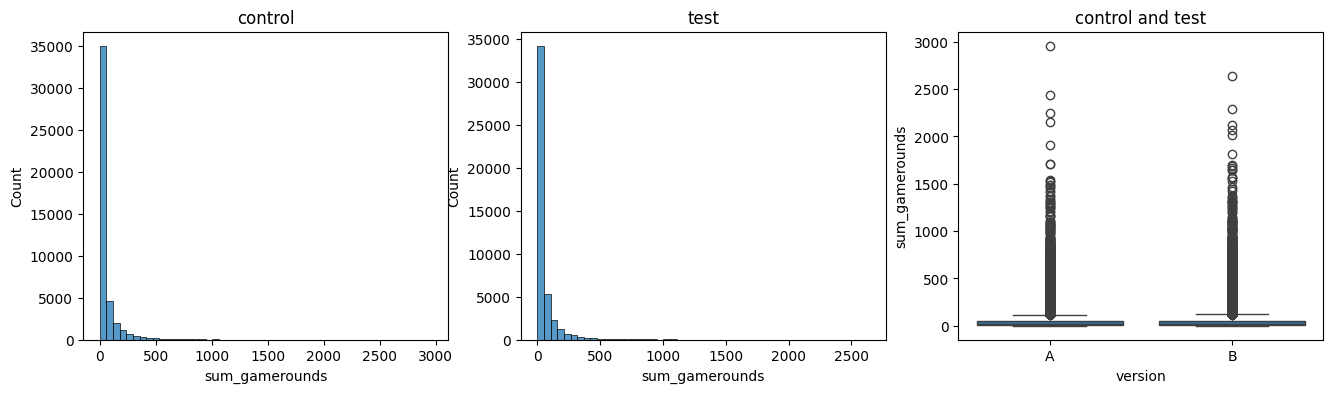

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].set_title('control')
sns.histplot(control.sum_gamerounds, bins=50, ax=axes[0])
axes[1].set_title('test')
sns.histplot(test.sum_gamerounds, bins=50, ax=axes[1])
axes[2].set_title('control and test')
sns.boxplot(data=all_data, x='version', y='sum_gamerounds', ax=axes[2]);

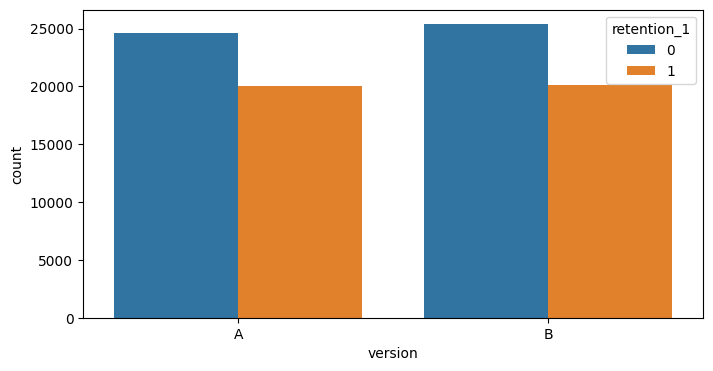

In [13]:
fig = plt.figure(figsize=(8, 4))
sns.countplot(all_data, x='version', hue='retention_1');

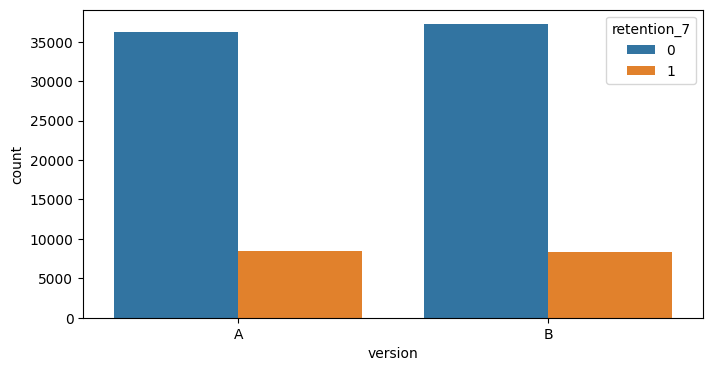

In [14]:
fig = plt.figure(figsize=(8, 4))
sns.countplot(all_data, x='version', hue='retention_7');

---

> ## Выдвенем несколько предположений:
### 1. Среднее количество раундов, пройденных игроками, увеличилось.
### 2. Процент людей, вернувшихся в игру на следующий день после установки, статистически-значимо изменился в тестовой группе.
### 3. Процент людей, вернувшихся в игру на седьмой день после установки, статистически-значимо изменился в тестовой группе.


---

> ### 1. **Сформулируем H0 и H1:**

- H0 - Средние meanA = meanB, т.е. выборки принадлежат одной генеральной совокупности.
- H1 - meanA != meanB, выборки принадлежат разным генеральным совокупностям.

Посмотрев на графики выше, можно убедиться, что распределение раундов отличается от нормального. Поэтому для проверки данной гипотизы будем использовать такой метод как бутстрап(bootstrap).

Суть этого метода заключается в следующем: Для каждой из групп формируем выборки с возвращением, считаем их средние и запоминаем их разницу. Повторяем этот процесс n раз. Таким образом, мы имитируем провередние многократное проведение эксперемента и по распределению полученной метрики считаем доверительный интервал. Если он включает не включает 0, то различия можно считать статистически значимыми.

In [15]:
def bootstrap(x: pd.Series, y: pd.Series, func, alpha: float=0.05, n_boots: int=10000):
    diffs = []
    for _ in tqdm(range(n_boots)):
        # Формируем бутстрапированные выборки
        x_ = x.sample(n=len(x), replace=True)
        y_ = y.sample(n=len(y), replace=True)

        # Cчитаем разницу выборочных средних
        diff = func(x_) - func(y_)
        diffs.append(diff)

    diffs = pd.Series(diffs)
    return (diffs.quantile(alpha/2), diffs.quantile(1-alpha/2)), diffs


In [16]:
result = bootstrap(x=control.sum_gamerounds, y=test.sum_gamerounds, func=np.mean)

100%|██████████| 10000/10000 [00:19<00:00, 509.52it/s]


Доверительный интервал: (np.float64(-1.3039485663280963), np.float64(1.392579278779257))


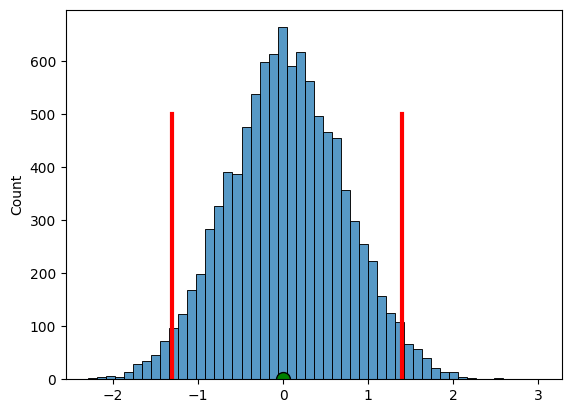

In [17]:
sns.histplot(result[1], bins=50);
sns.lineplot(x=(result[0][0], result[0][0]), y=(0, 500), estimator=None, linewidth=3, c='red')
sns.lineplot(x=(result[0][1], result[0][1]), y=(0, 500), estimator=None, linewidth=3, c='red')
plt.scatter(x=0, y=0, c='g', s=100, edgecolors='0')
print(f'Доверительный интервал: {result[0]}')

У нас нет никаких оснований отклонить нулевую гипотезу о равенстве средних. Однако, воспользуемся дополнительно U-критерий Манна — Уитни чтобы убедиться, что различия статистически незначимы.

In [18]:
sc.mannwhitneyu(control.sum_gamerounds, test.sum_gamerounds)

MannwhitneyuResult(statistic=np.float64(1024285761.5), pvalue=np.float64(0.05089155279145376))

---

> ### 2. **Сформулируем H0 и H1:**

- H0 - Распределение людей, вернувшихися на следующий день в тестовой и контрольной группе не отличаются. т.е. процент людей, вернувшихся на следующий день после установки не изменилось.
- H1 - Распределения отличаются.

Т.к. версия и retention_1 являются номинативными признаками, то для проверки гипотезы об отсутствии различий в тестовой и контрольной группе при условии, что верна нулевая гипотеза, воспользуемся критерием $\chi^2$. Также эту гипотезу можно проверить с помощью бутстрэпа.

In [19]:
all_data.groupby('version').retention_1.mean()

version
A    0.448198
B    0.442283
Name: retention_1, dtype: float64

In [20]:
retention1_ct = pd.crosstab(all_data.version, all_data.retention_1)
retention1_ct

retention_1,0,1
version,,
A,24665,20034
B,25370,20119


In [21]:
sc.chi2_contingency(retention1_ct)

Chi2ContingencyResult(statistic=np.float64(3.169835543170799), pvalue=np.float64(0.07500999897705692), dof=1, expected_freq=array([[24798.35970417, 19900.64029583],
       [25236.64029583, 20252.35970417]]))

Опираясь на критерий $\chi^2$, можно сделать вывод, что показатель retention_1 в тестовой группе статистически-значимо не отличается. Однако p-уровень значимости слишком близок к границе статистического вывода. Поэтому, чтобы убедиться в достоверности полученных выше значений, применим бутстрэп.

In [22]:
result = bootstrap(control.retention_1, test.retention_1, np.mean)

100%|██████████| 10000/10000 [00:19<00:00, 517.97it/s]


Доверительный интервал: (np.float64(-0.0003931924643738744), np.float64(0.012485306841456758))


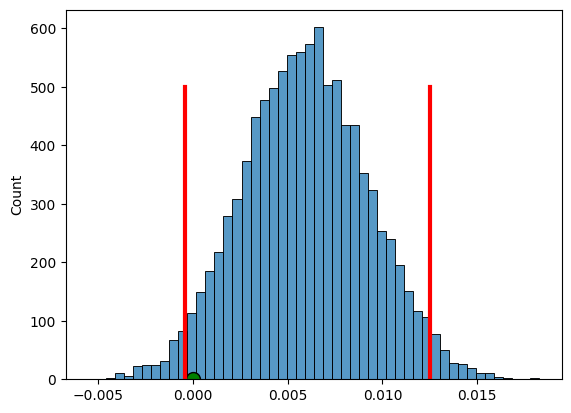

In [23]:
sns.histplot(result[1], bins=50);
sns.lineplot(x=(result[0][0], result[0][0]), y=(0, 500), estimator=None, linewidth=3, c='red')
sns.lineplot(x=(result[0][1], result[0][1]), y=(0, 500), estimator=None, linewidth=3, c='red')
plt.scatter(x=0, y=0, c='g', s=100, edgecolors='0')
print(f'Доверительный интервал: {result[0]}')

Доверительный интервал включает 0, что говорит о том, что распределения retention_1 в контрольной и тестовой выборке **не отличаются**.

---

> ### 3. **Сформулируем H0 и H1:**

- H0 - Распределение людей, вернувшихися на седьмой день в тестовой и контрольной группе не отличаются. Т.е. процент людей, вернувшихся на следующий день после установки не изменился.
- H1 - Распределения отличаются.

Воспользуемся теми же критериями:

In [24]:
all_data.groupby('version').retention_7.mean()

version
A    0.190183
B    0.182000
Name: retention_7, dtype: float64

In [25]:
retention7_ct = pd.crosstab(all_data.version, all_data.retention_7)
retention7_ct

retention_7,0,1
version,,
A,36198,8501
B,37210,8279


In [26]:
sc.chi2_contingency(retention7_ct)

Chi2ContingencyResult(statistic=np.float64(9.91527552890567), pvalue=np.float64(0.0016391259678654425), dof=1, expected_freq=array([[36382.49203885,  8316.50796115],
       [37025.50796115,  8463.49203885]]))

$\chi^2$ показал что ожидаемая и фактическая выборка в тестовой группе **статистически-значимо отличаются**. Это значит, что обновленная версия повлияла на игру, но в **худшую** сторону, т.к. retention 7-го дня просел. Закрепим этот результат.

In [27]:
result = bootstrap(control.retention_7, test.retention_7, np.mean)

100%|██████████| 10000/10000 [00:19<00:00, 512.20it/s]


Доверительный интервал: (np.float64(0.003097310207720904), np.float64(0.013342942575400913))


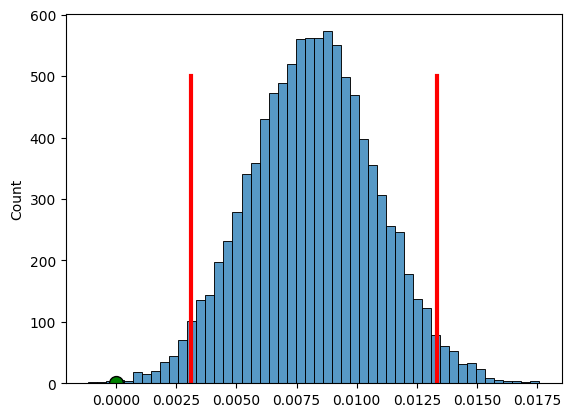

In [28]:
sns.histplot(result[1], bins=50);
sns.lineplot(x=(result[0][0], result[0][0]), y=(0, 500), estimator=None, linewidth=3, c='red')
sns.lineplot(x=(result[0][1], result[0][1]), y=(0, 500), estimator=None, linewidth=3, c='red')
plt.scatter(x=0, y=0, c='g', s=100, edgecolors='0')
print(f'Доверительный интервал: {result[0]}')

Заключение:
Среднее количество сыгранных раундов и retention первого дня не изменился, однако показатель retention 7 дня изменлился в худшую сторону в версии с вратами после 40-го уровня. Это говорит о том, что пользователи теряют интерес к данному продукту и покидают его.

Вывод: откатываем обновление и придумываем новые способы улучшения метрик.